In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%load_ext lab_black

In [141]:
titanic = pd.read_csv("train.csv")

In [142]:
titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [143]:
# Missing values in percent
titanic.isnull().sum() / len(titanic) * 100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

### Data understanding

<AxesSubplot: >

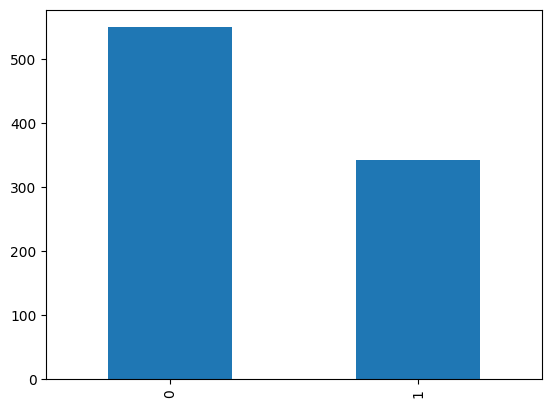

In [144]:
titanic["Survived"].value_counts().plot(kind="bar")

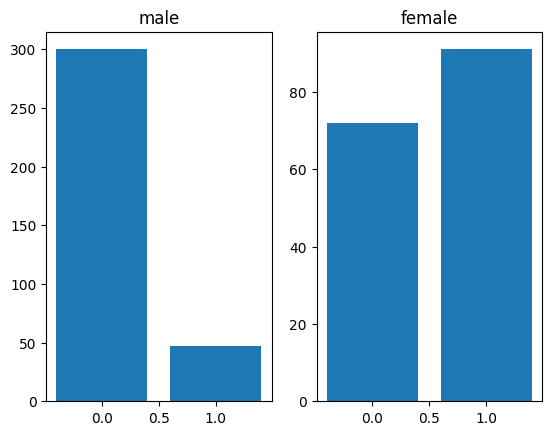

In [145]:
fig, ax = plt.subplots(1, len(titanic["Sex"].unique()))
for i, gender in enumerate(titanic["Sex"].unique()):
    _temp_df = titanic.query(f"Sex == '{gender}'")
    gender_values = _temp_df.groupby(["Pclass"])["Survived"].value_counts().droplevel(0)
    ax = plt.subplot(1, 2, i + 1)
    ax.bar(x=gender_values.index, height=gender_values)
    ax.set_title(f"{gender}")

Survived
1    91
0     3
1    70
0     6
0    72
1    72
Name: Survived, dtype: int64
Survived
1    91
0     3
1    70
0     6
0    72
1    72
Name: Survived, dtype: int64


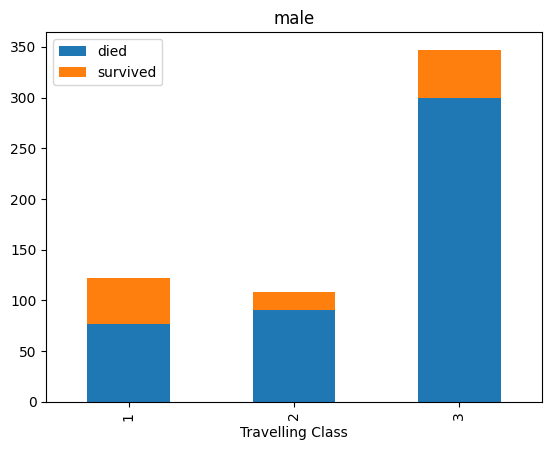

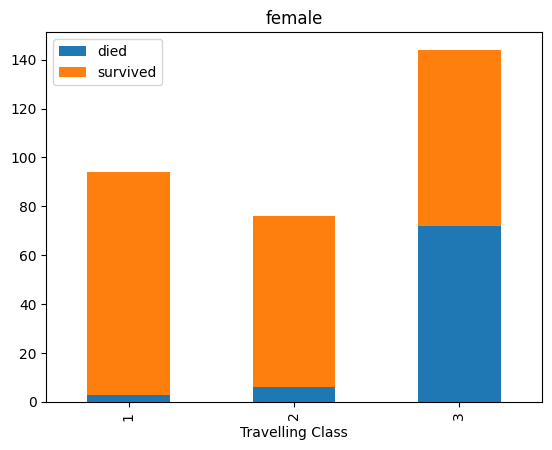

In [146]:
for i, gender in enumerate(titanic["Sex"].unique()):
    _temp_df = titanic.query(f"Sex == '{gender}'")
    axes = (
        _temp_df.groupby(["Pclass"])["Survived"]
        .value_counts()
        .unstack()
        .plot(kind="bar", stacked=True, title=f"{gender}")
    )
    axes.legend(["died", "survived"])
    axes.set_xlabel("Travelling Class")
    print(gender_values)

<AxesSubplot: title={'center': 'histogram of age'}, ylabel='Frequency'>

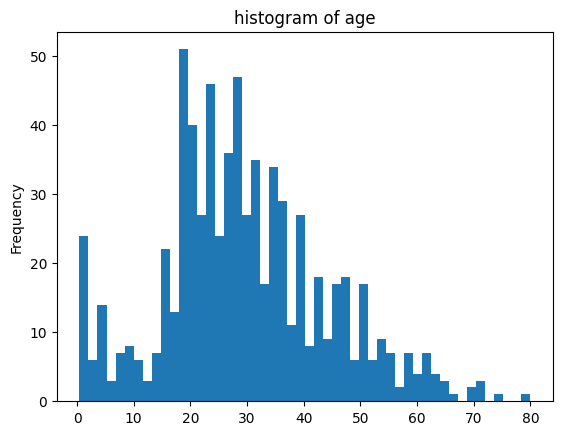

In [147]:
titanic["Age"].plot(kind="hist", bins=50, title="histogram of age")

In [148]:
kids = titanic.query("Age <= 18")
adults = titanic.query("Age > 18")

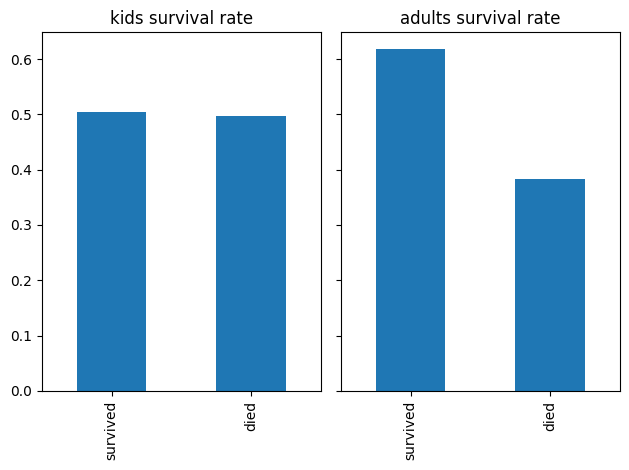

In [149]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

# ax1 = kids["Survived"].value_counts().plot(kind="bar", title="kids survival rate")
kids["Survived"].value_counts(normalize=True).plot(
    kind="bar", title="kids survival rate", ax=ax1
)
# ax[1] = adults["Survived"].value_counts().plot(kind="bar", title="adults survival rate")
adults["Survived"].value_counts(normalize=True).plot(
    kind="bar",
    title="adults survival rate",
    ax=ax2,
)
ax1.set_xticklabels(["survived", "died"])
ax2.set_xticklabels(["survived", "died"])
fig.tight_layout()

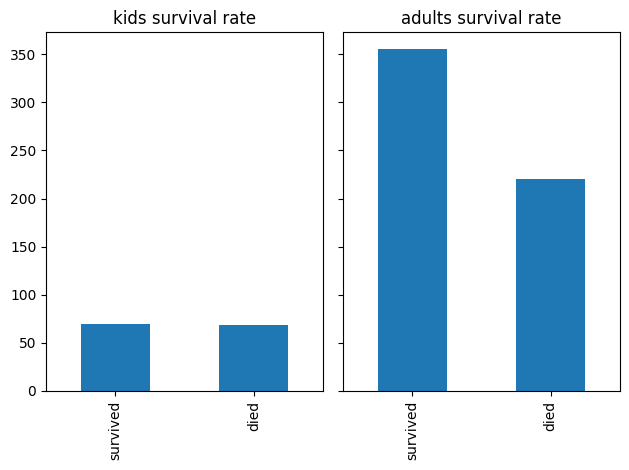

In [150]:
# Alternative
fig, axes = plt.subplots(1, 2, sharey=True)

# ax1 = kids["Survived"].value_counts().plot(kind="bar", title="kids survival rate")
kids["Survived"].value_counts().plot(kind="bar", title="kids survival rate", ax=axes[0])
# ax[1] = adults["Survived"].value_counts().plot(kind="bar", title="adults survival rate")
adults["Survived"].value_counts().plot(
    kind="bar",
    title="adults survival rate",
    ax=axes[1],
)
axes[0].set_xticklabels(["survived", "died"])
axes[1].set_xticklabels(["survived", "died"])
fig.tight_layout()

In [151]:
titanic.groupby(["Survived"])["Age"].mean()

Survived
0    30.626179
1    28.343690
Name: Age, dtype: float64

In [152]:
def has_family(row: pd.Series) -> int:
    if row["SibSp"] != 0 or row["Parch"] != 0:
        return 1
    else:
        return 0


titanic["family"] = titanic.apply(lambda row: has_family(row), axis=1)

Text(0.5, 1.0, 'Heatmap of all features')

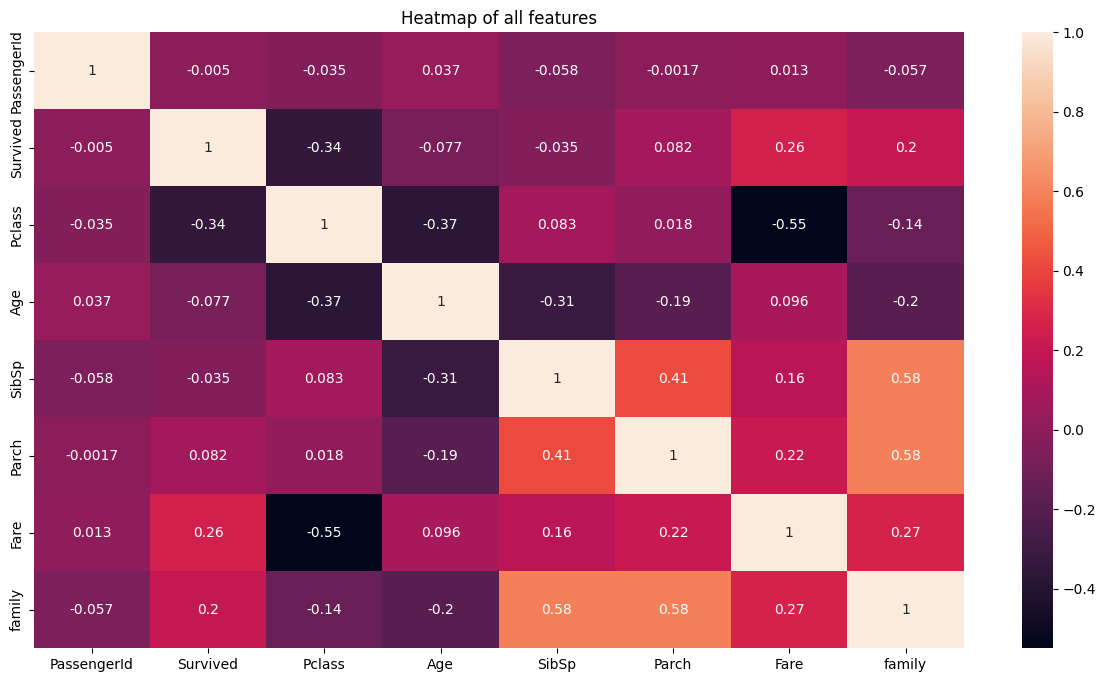

In [153]:
plt.figure(figsize=(15, 8))
sns.heatmap(titanic.corr(numeric_only=True), annot=True)
plt.title("Heatmap of all features")

<AxesSubplot: xlabel='Age', ylabel='Fare'>

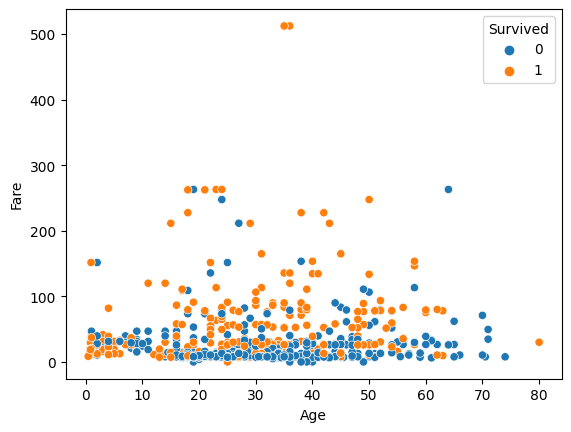

In [154]:
sns.scatterplot(data=titanic, x="Age", y="Fare", hue="Survived")

### Build model
Lets try logistic regression  
then lets try decision tree --> random forest
finally something like k means

In [155]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics

In [156]:
df = titanic.copy()

In [157]:
gender_to_num = {"male": 0, "female": 1}
df["gender_num"] = df["Sex"].map(gender_to_num)

In [158]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family,gender_num
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0


Train_test_split
for now we skip the age, but maybe we can find a way to use it later

In [159]:
X = df[["Pclass", "gender_num", "family"]]
y = df["Survived"]

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [161]:
X_train.isnull().sum()

Pclass        0
gender_num    0
family        0
dtype: int64

In [162]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 668 entries, 839 to 216
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Pclass      668 non-null    int64
 1   gender_num  668 non-null    int64
 2   family      668 non-null    int64
dtypes: int64(3)
memory usage: 20.9 KB


In [163]:
model = LogisticRegression()
model.fit(X_train.values, y_train.values)

LogisticRegression()

In [164]:
result = model.predict(X_test.values)

In [165]:
cnf_matrix = metrics.confusion_matrix(y_test, result)
cnf_matrix

array([[112,  24],
       [ 26,  61]], dtype=int64)

In [166]:
print(metrics.classification_report(y_test, result))

              precision    recall  f1-score   support

           0       0.81      0.82      0.82       136
           1       0.72      0.70      0.71        87

    accuracy                           0.78       223
   macro avg       0.76      0.76      0.76       223
weighted avg       0.77      0.78      0.78       223



Text(0.5, 427.9555555555555, 'Predicted label')

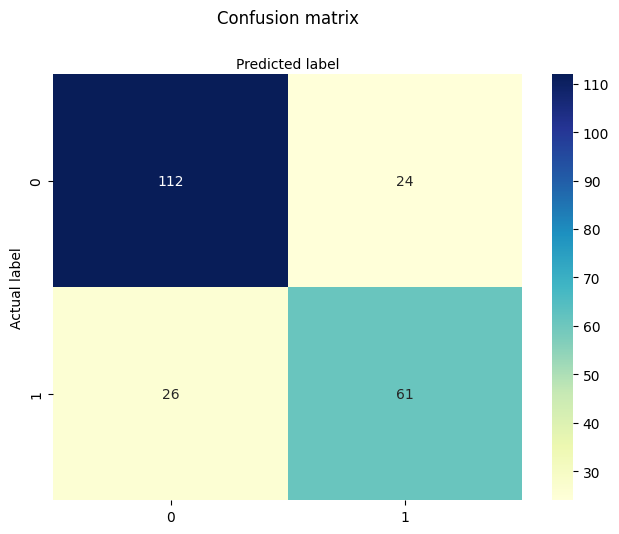

In [167]:
class_names = [0, 1]  # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt="g")
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion matrix", y=1.1)
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

# Text(0.5, 257.44, "Predicted label")

## Imbalanced dataset, lets take it into account

In [168]:
# Searching best class_weight value using GridSearchCV
class_weights = [{1: i * 0.01} for i in range(1, 100, 2)]
param_grid = {"class_weight": class_weights}
logistic_reg = LogisticRegression(random_state=1)
lr_grid = GridSearchCV(
    estimator=logistic_reg, param_grid=param_grid, cv=100, verbose=1, n_jobs=-1
)

lr_grid.fit(X_train, y_train)

Fitting 100 folds for each of 50 candidates, totalling 5000 fits


GridSearchCV(cv=100, estimator=LogisticRegression(random_state=1), n_jobs=-1,
             param_grid={'class_weight': [{1: 0.01}, {1: 0.03}, {1: 0.05},
                                          {1: 0.07}, {1: 0.09}, {1: 0.11},
                                          {1: 0.13}, {1: 0.15}, {1: 0.17},
                                          {1: 0.19}, {1: 0.21}, {1: 0.23},
                                          {1: 0.25}, {1: 0.27}, {1: 0.29},
                                          {1: 0.31}, {1: 0.33},
                                          {1: 0.35000000000000003}, {1: 0.37},
                                          {1: 0.39}, {1: 0.41000000000000003},
                                          {1: 0.43}, {1: 0.45},
                                          {1: 0.47000000000000003}, {1: 0.49},
                                          {1: 0.51}, {1: 0.53}, {1: 0.55},
                                          {1: 0.5700000000000001}, {1: 0.59}, ...]},
             verbose=1)

In [169]:
lr_grid.best_params_

{'class_weight': {1: 0.71}}

In [170]:
lr_grid.best_score_

0.7909523809523809

In [171]:
logistic_reg = LogisticRegression(random_state=1, class_weight={1: 0.27})
logistic_reg.fit(X_train, y_train)
result = logistic_reg.predict(X_test)

In [172]:
cnf_matrix = metrics.confusion_matrix(y_test, result)

In [173]:
print(metrics.classification_report(y_test, result))

              precision    recall  f1-score   support

           0       0.75      0.97      0.85       136
           1       0.92      0.51      0.65        87

    accuracy                           0.79       223
   macro avg       0.84      0.74      0.75       223
weighted avg       0.82      0.79      0.77       223



Text(0.5, 427.9555555555555, 'Predicted label')

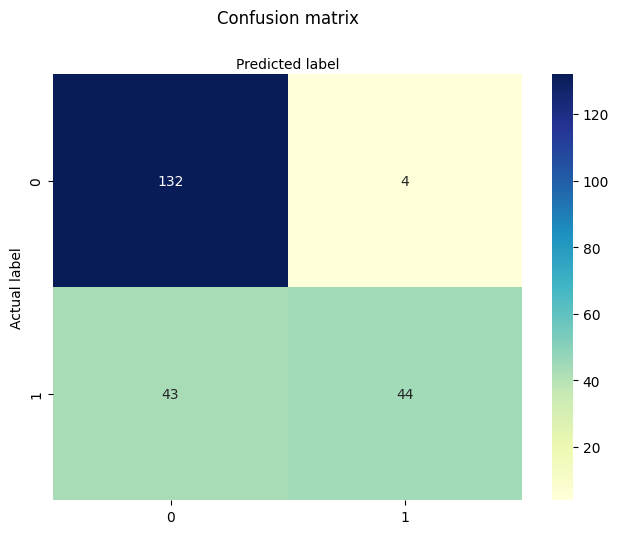

In [174]:
class_names = [0, 1]  # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt="g")
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion matrix", y=1.1)
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

## Decision Tree

In [175]:
from sklearn import tree
import graphviz
import os

os.environ["PATH"] += os.pathsep + "C:\\Program Files\\Graphviz\\bin"

In [176]:
tree_model = tree.DecisionTreeClassifier()
tree_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [177]:
tree_pred = tree_model.predict(X_test)

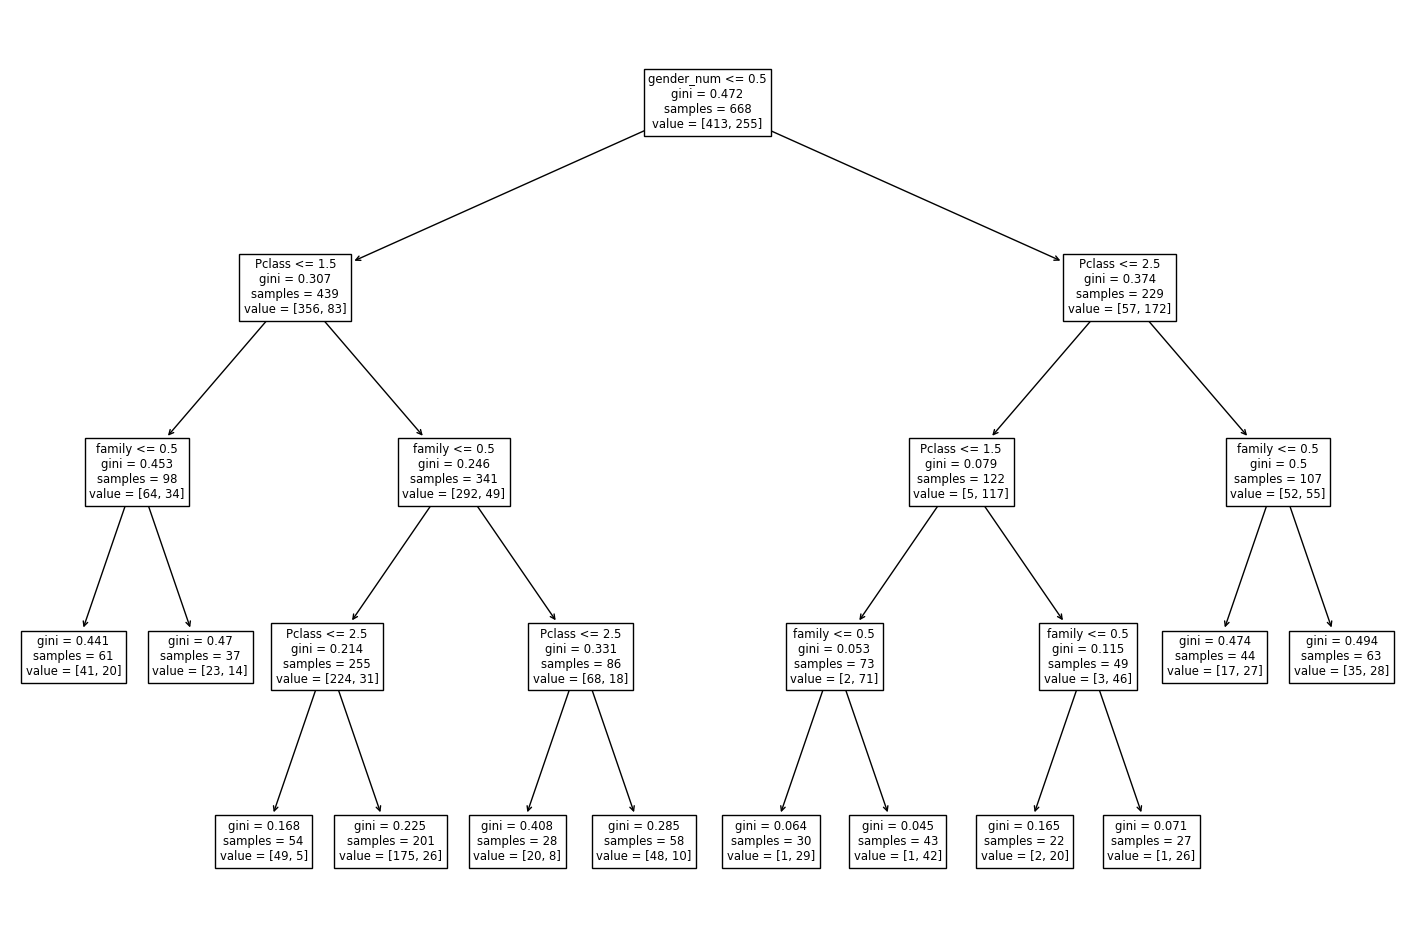

In [178]:
plt.figure(figsize=(18, 12))
tree.plot_tree(tree_model, feature_names=["Pclass", "gender_num", "family"])
plt.show()

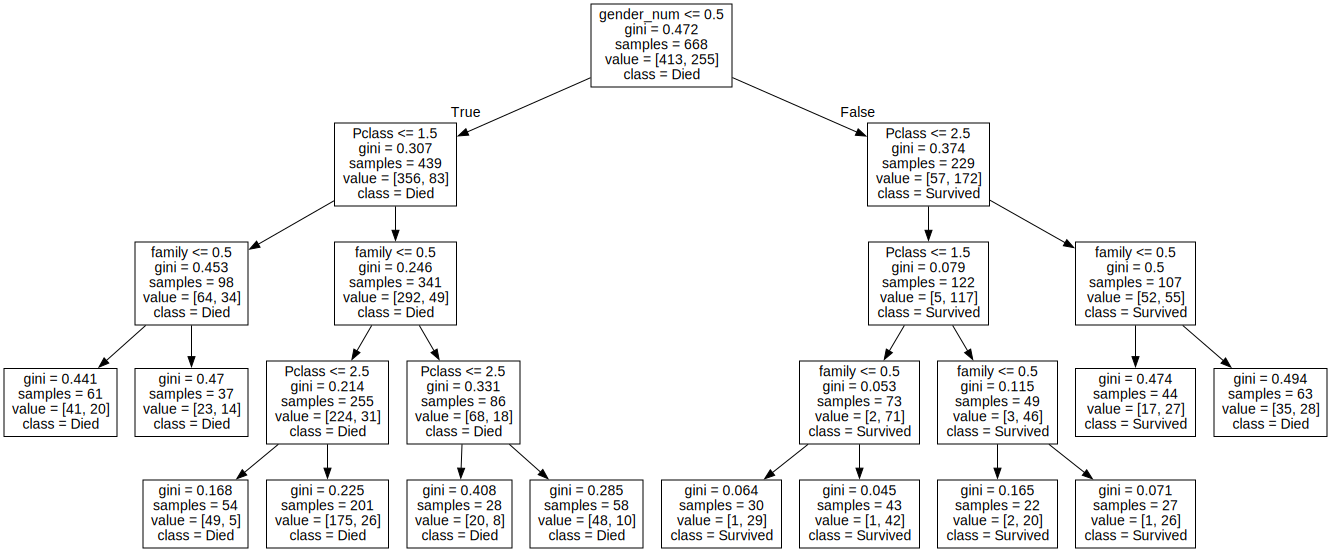

In [179]:
dot_data = tree.export_graphviz(
    tree_model,
    out_file=None,
    feature_names=["Pclass", "gender_num", "family"],
    class_names=["Died", "Survived"],
)
graph = graphviz.Source(dot_data)
graph

In [180]:
print(metrics.classification_report(y_test, result))

              precision    recall  f1-score   support

           0       0.75      0.97      0.85       136
           1       0.92      0.51      0.65        87

    accuracy                           0.79       223
   macro avg       0.84      0.74      0.75       223
weighted avg       0.82      0.79      0.77       223



In [181]:
cnf_matrix_tree = metrics.confusion_matrix(y_test, tree_pred)

Text(0.5, 427.9555555555555, 'Predicted label')

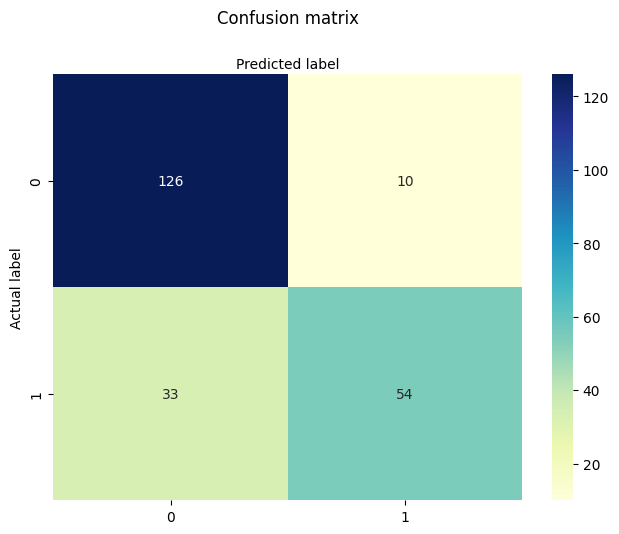

In [182]:
class_names = ["died", "survived"]  # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_tree), annot=True, cmap="YlGnBu", fmt="g")
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion matrix", y=1.1)
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

## Random Forest Classifier

In [183]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [184]:
model_forest = RandomForestClassifier(random_state=1)
model_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [185]:
result_forest = model_forest.predict(X_test)

In [186]:
print(metrics.classification_report(y_test, result_forest))

              precision    recall  f1-score   support

           0       0.79      0.93      0.85       136
           1       0.84      0.62      0.72        87

    accuracy                           0.81       223
   macro avg       0.82      0.77      0.78       223
weighted avg       0.81      0.81      0.80       223



In [187]:
cnf_matrix_forest = metrics.confusion_matrix(y_test, result_forest)

Text(0.5, 427.9555555555555, 'Predicted label')

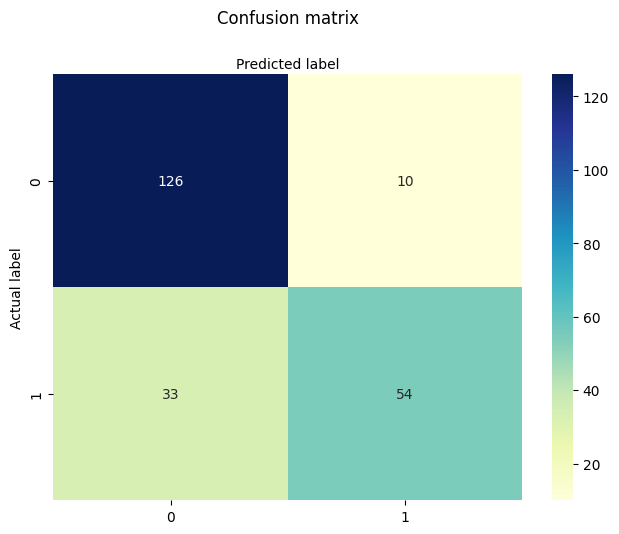

In [188]:
class_names = ["died", "survived"]  # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_forest), annot=True, cmap="YlGnBu", fmt="g")
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion matrix", y=1.1)
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

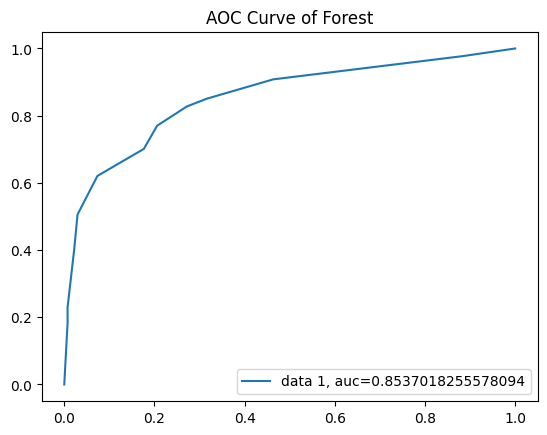

In [189]:
y_pred_proba = model_forest.predict_proba(X_test)[::, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="data 1, auc=" + str(auc))
plt.legend(loc=4)
plt.title("AOC Curve of Forest")
plt.show()

## Kmeanst cluster

In [190]:
from sklearn.cluster import KMeans

In [191]:
kmeans = KMeans(n_clusters=2, random_state=1).fit(X_train, y_train)
kmeans_result = kmeans.predict(X_test)

In [192]:
print(metrics.classification_report(y_test, kmeans_result))

              precision    recall  f1-score   support

           0       0.78      0.71      0.74       136
           1       0.60      0.68      0.64        87

    accuracy                           0.70       223
   macro avg       0.69      0.70      0.69       223
weighted avg       0.71      0.70      0.70       223



In [193]:
cnf_matrix_kmeans = metrics.confusion_matrix(y_test, kmeans_result)

Text(0.5, 427.9555555555555, 'Predicted label')

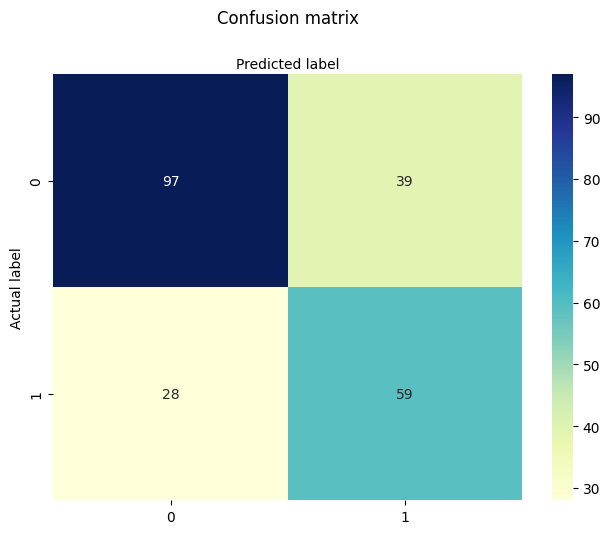

In [194]:
class_names = ["died", "survived"]  # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_kmeans), annot=True, cmap="YlGnBu", fmt="g")
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion matrix", y=1.1)
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

## SVM

In [195]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [196]:
model_svm = make_pipeline(StandardScaler(), SVC())
model_svm.fit(X_train, y_train)
result_svm = model_svm.predict(X_test)

In [197]:
print(metrics.classification_report(y_test, result_svm))

              precision    recall  f1-score   support

           0       0.79      0.93      0.85       136
           1       0.84      0.62      0.72        87

    accuracy                           0.81       223
   macro avg       0.82      0.77      0.78       223
weighted avg       0.81      0.81      0.80       223



In [198]:
cnf_matrix_svm = metrics.confusion_matrix(y_test, result_svm)

Text(0.5, 427.9555555555555, 'Predicted label')

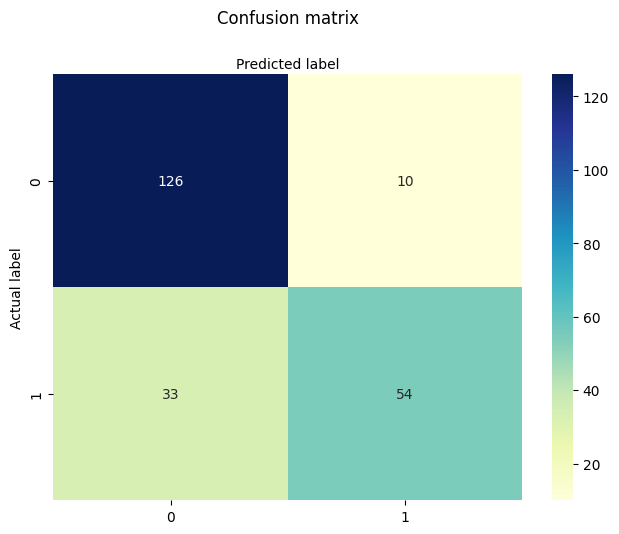

In [199]:
class_names = ["died", "survived"]  # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_svm), annot=True, cmap="YlGnBu", fmt="g")
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion matrix", y=1.1)
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

### Load test

In [200]:
test = pd.read_csv("test.csv")